## Importation des bibliotheques

In [4]:
import pandas as pd 
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import random
from torch.utils.data import Dataset, DataLoader, random_split
from glob import glob
import timm
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import f1_score, classification_report

## Verification du GPU

In [5]:
print("GPU disponible :", torch.cuda.is_available())
print("Nom du GPU :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Aucun")


GPU disponible : False
Nom du GPU : Aucun


## Chargement et analyse des donnees

In [6]:
# Chemin du dossier principal
base_path = "/kaggle/input/african-plums-quality-and-defect-assessment-data/african_plums_dataset"

# Lister les sous-dossiers (classes)
classes = os.listdir(base_path)
print("Classes disponibles :", classes)

Classes disponibles : ['README.md', 'organized_plums_data_new.csv', 'african_plums']


In [7]:
# Chemin vers le dossier african_plums
plums_path = os.path.join(base_path, "african_plums")

# Vérification que le chemin existe
if not os.path.exists(plums_path):
    print("Erreur : Le dossier african_plums n'existe pas à l'emplacement spécifié.")
    print("Contenu du dossier african_plums_dataset :")
    print(os.listdir(base_path))
else:
    print("Dossier african_plums trouvé avec succès !")

Dossier african_plums trouvé avec succès !


In [8]:
if os.path.exists(plums_path):
    # Lister tous les sous-dossiers (classes)
    classes = [d for d in os.listdir(plums_path) 
              if os.path.isdir(os.path.join(plums_path, d))]
    
    print("\nNombre d'images par classe :")
    print("----------------------------")
    
    for class_name in classes:
        class_path = os.path.join(plums_path, class_name)
        num_images = len([f for f in os.listdir(class_path) 
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
        print(f"{class_name}: {num_images} images")


Nombre d'images par classe :
----------------------------
unripe: 826 images
cracked: 162 images
rotten: 720 images
spotted: 759 images
bruised: 319 images
unaffected: 1721 images


In [9]:
if os.path.exists(plums_path):
    # Préparer les données pour un DataFrame
    data = []
    
    for class_name in os.listdir(plums_path):
        class_path = os.path.join(plums_path, class_name)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            data.append({
                "Classe": class_name,
                "Nombre d'images": len(images),
                "Exemple de fichier": images[0] if images else "Aucune"
            })
    
    # Créer et afficher le DataFrame
    df = pd.DataFrame(data)
    print(df)
    
    # Statistiques supplémentaires
    print("\nTotal d'images:", df["Nombre d'images"].sum())

       Classe  Nombre d'images       Exemple de fichier
0      unripe              826      unripe_plum_644.png
1     cracked              162      cracked_plum_42.png
2      rotten              720      rotten_plum_584.png
3     spotted              759     spotted_plum_346.png
4     bruised              319     bruised_plum_144.png
5  unaffected             1721  unaffected_plum_970.png

Total d'images: 4507


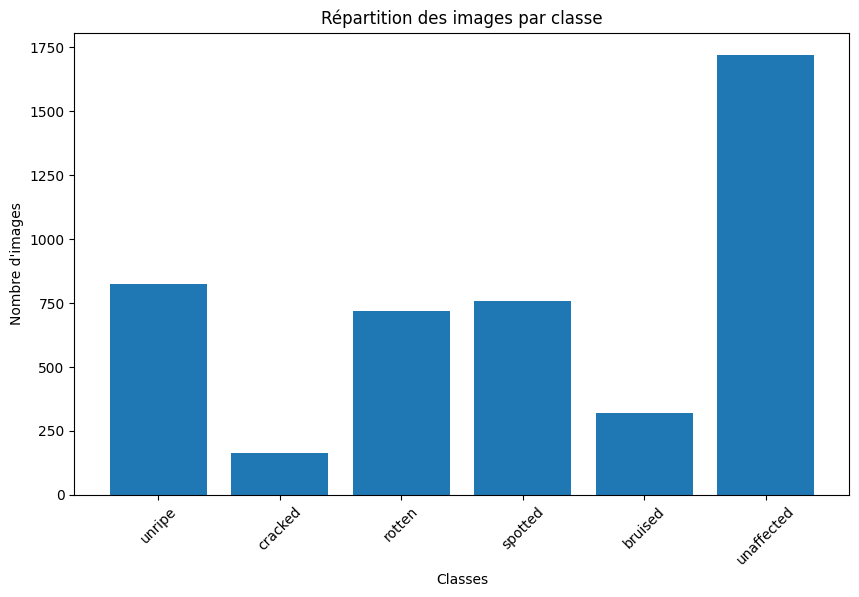

In [10]:
if not df.empty:
    plt.figure(figsize=(10, 6))
    plt.bar(df["Classe"], df["Nombre d'images"])
    plt.title("Répartition des images par classe")
    plt.xlabel("Classes")
    plt.ylabel("Nombre d'images")
    plt.xticks(rotation=45)
    plt.show()

## Calcul des statistiques

In [11]:
# 1. Récupération de tous les chemins d'images
root_dir = plums_path
valid_exts = (".jpg", ".jpeg", ".png", ".bmp")

all_image_paths = [
    os.path.join(dp, f)
    for dp, dn, filenames in os.walk(root_dir)
    for f in filenames
    if f.lower().endswith(valid_exts)
]

# 2. Tirage aléatoire de 1000 images (ou moins si pas assez)
sample_paths = random.sample(all_image_paths, min(1000, len(all_image_paths)))

# 3. Préparation du transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

means, stds = [], []

# 4. Parcours des images
for path in sample_paths:
    try:
        img = Image.open(path).convert('RGB')
        t_img = transform(img)
        means.append(t_img.mean(dim=(1, 2)))
        stds.append(t_img.std(dim=(1, 2)))
    except Exception as e:
        print(f"Erreur avec l'image {path}: {e}")

# 5. Calcul des moyennes
if means and stds:
    mean = torch.mean(torch.stack(means), dim=0)
    std = torch.mean(torch.stack(stds), dim=0)
    print(f"Moyenne : {mean}")
    print(f"Écart-type : {std}")
else:
    print("Aucune image valide n'a été traitée.")


Moyenne : tensor([0.5879, 0.5112, 0.5117])
Écart-type : tensor([0.1905, 0.2089, 0.2003])


In [12]:
plums_path

'/kaggle/input/african-plums-quality-and-defect-assessment-data/african_plums_dataset/african_plums'

## Transformation

In [13]:
standard_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Uniformise la taille pour tous les modèles pré-entraînés
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),# Convertit les images PIL en tenseurs PyTorch
    transforms.Normalize(mean=mean, std=std)# Normalisation avec les valeurs calculées
])

augmented_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1)),  # Masquage aléatoire
    transforms.Normalize(mean=mean, std=std)
])

## Création d’un dataset personnalisé avec augmentation ciblée

In [14]:
class CustomPlumDataset(Dataset):
    def __init__(self, root_dir, class_to_idx, transform_normal, transform_augmented, minority_classes):
        self.image_paths = glob(f"{root_dir}/*/*.png")
        self.class_to_idx = class_to_idx
        self.transform_normal = transform_normal
        self.transform_augmented = transform_augmented
        self.minority_classes = minority_classes

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_name = os.path.basename(os.path.dirname(img_path))
        label = self.class_to_idx[label_name]
        image = Image.open(img_path).convert("RGB")
        
 # Si l’image appartient à une classe minoritaire, on applique des augmentations
        if label_name in self.minority_classes:
            image = self.transform_augmented(image)
        else:
            image = self.transform_normal(image)

        return image, label

## Préparation des noms de classes, mapping et dataset

In [15]:
DATA_DIR = plums_path
class_names = sorted(os.listdir(DATA_DIR)) # Liste triée des noms de classes
class_to_idx = {cls: i for i, cls in enumerate(class_names)}  
minority_classes = ['cracked', 'bruised'] # Classes à augmenter

dataset = CustomPlumDataset(DATA_DIR, class_to_idx, standard_transform, augmented_transform, minority_classes)


## Decoupage train val test

In [16]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

#Découpage du dataset selon les tailles définies
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

#Chargement des données sous forme de DataLoader
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)# Le shuffle évite les biais d’ordre
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

## Utilisation de la weightedLoss pour augmenter les poids des classes sous representés

In [23]:
def get_class_weights(dataset, num_classes):
    from collections import Counter

    targets = [label for _, label in dataset]
    class_counts = Counter(targets)
    
    total = sum(class_counts.values())

    # Si une classe est absente, on lui met un poids 0 pour ne pas la considérer
    weights = [total / class_counts[i] if class_counts[i] > 0 else 0.0 for i in range(num_classes)]

    weights = torch.tensor(weights, dtype=torch.float)
    return weights


## Entrainement 

In [24]:
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import f1_score

def train_model(model_name, train_loader, val_loader, device, epochs=10, lr=3e-4, save_path='best_model.pth', patience=5):
    # Initialisation du modèle, de la fonction de perte et de l'optimiseur
    model = build_model(model_name).to(device)
    #criterion = nn.CrossEntropyLoss()
    # Suppose que tu as déjà accès à ton dataset d'entraînement
    class_weights = get_class_weights(train_set, num_classes=6).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    best_val_f1 = 0
    best_epoch = 0
    early_stop_counter = 0  # Compteur pour l'arrêt précoce

    # Listes pour sauvegarder les pertes et les F1-scores
    train_losses, val_losses = [], []
    train_f1s, val_f1s = [], []

    for epoch in range(epochs):
        model.train()
        train_loss, y_true, y_pred = 0, [], []
        
        # Entraînement sur les batches
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            y_true += labels.cpu().tolist()
            y_pred += outputs.argmax(1).cpu().tolist()
        
        # Calcul du F1-score et sauvegarde de la perte d'entraînement
        train_f1 = f1_score(y_true, y_pred, average='macro')
        train_losses.append(train_loss / len(train_loader))
        train_f1s.append(train_f1)
        print(f"\nEpoch {epoch+1} /50 - Train F1: {train_f1:.4f} | Loss: {train_loss/len(train_loader):.4f}")

        # Validation
        model.eval()
        val_loss, y_true, y_pred = 0, [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                y_true += labels.cpu().tolist()
                y_pred += outputs.argmax(1).cpu().tolist()
        
        # Calcul du F1-score et sauvegarde de la perte de validation
        val_f1 = f1_score(y_true, y_pred, average='macro')
        val_losses.append(val_loss / len(val_loader))
        val_f1s.append(val_f1)
        print(f"Validation F1: {val_f1:.4f} | Loss: {val_loss/len(val_loader):.4f}")

        # Sauvegarde du meilleur modèle et early stopping
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_epoch = epoch
            torch.save(model.state_dict(), save_path)
            print("✅ Meilleur modèle sauvegardé !")
            early_stop_counter = 0  # Réinitialisation du compteur
        else:
            early_stop_counter += 1
        
        # Early stopping : si l'amélioration n'a pas lieu après 'patience' époques, arrêter
        if early_stop_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs without improvement.")
            break

    return model, train_losses, val_losses, train_f1s, val_f1s


## Construction du model

In [25]:
import torch.nn as nn
from torchvision import models

def build_model(model_name='densenet121', num_classes=6):
    if model_name == 'densenet121':
        model = models.densenet121(pretrained=True)

        # Étape 1 : Geler tous les paramètres
        for param in model.parameters():
            param.requires_grad = False

        # Étape 2 : Remplacer la tête de classification
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)

        # Étape 3 : Dégeler la tête
        for param in model.classifier.parameters():
            param.requires_grad = True

        # Facultatif : dégeler les derniers blocs du backbone
        # Ici, on débloque les 2 derniers denseblocks (conv5, conv4)
        for name, param in model.features.denseblock4.named_parameters():
            param.requires_grad = True
        for name, param in model.features.transition3.named_parameters():
            param.requires_grad = True

    else:
        raise ValueError("Modèle non pris en charge")

    return model


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_densenet, train_losses_densenet, val_losses_densenet, train_f1s_densenet, val_f1s_densenet = train_model(
    model_name='densenet121',
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=50,
    lr=3e-4,
    save_path='densenet121_best.pth'
)



Epoch 1 /50 - Train F1: 0.6434 | Loss: 0.8194
Validation F1: 0.7563 | Loss: 0.5280
✅ Meilleur modèle sauvegardé !

Epoch 2 /50 - Train F1: 0.7576 | Loss: 0.5516
Validation F1: 0.7391 | Loss: 0.5219

Epoch 3 /50 - Train F1: 0.8111 | Loss: 0.4336
Validation F1: 0.7381 | Loss: 0.5544

Epoch 4 /50 - Train F1: 0.8375 | Loss: 0.3779
Validation F1: 0.7580 | Loss: 0.5027
✅ Meilleur modèle sauvegardé !

Epoch 5 /50 - Train F1: 0.8602 | Loss: 0.3345
Validation F1: 0.7937 | Loss: 0.5324
✅ Meilleur modèle sauvegardé !

Epoch 6 /50 - Train F1: 0.8782 | Loss: 0.2952
Validation F1: 0.8118 | Loss: 0.5202
✅ Meilleur modèle sauvegardé !

Epoch 7 /50 - Train F1: 0.8991 | Loss: 0.2534
Validation F1: 0.7599 | Loss: 0.5655

Epoch 8 /50 - Train F1: 0.8968 | Loss: 0.2392
Validation F1: 0.7519 | Loss: 0.6357

Epoch 9 /50 - Train F1: 0.8922 | Loss: 0.2376
Validation F1: 0.7626 | Loss: 0.6263

Epoch 10 /50 - Train F1: 0.9062 | Loss: 0.2230
Validation F1: 0.7554 | Loss: 0.6728

Epoch 11 /50 - Train F1: 0.8930 | 

In [28]:
def plot_training_curves(train_f1s, val_f1s, train_losses, val_losses):
    epochs = range(1, len(train_f1s) + 1)

    # Plot F1-score
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_f1s, label='Train F1', color='blue')
    plt.plot(epochs, val_f1s, label='Validation F1', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('F1-score')
    plt.title('Train vs Validation F1-score')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


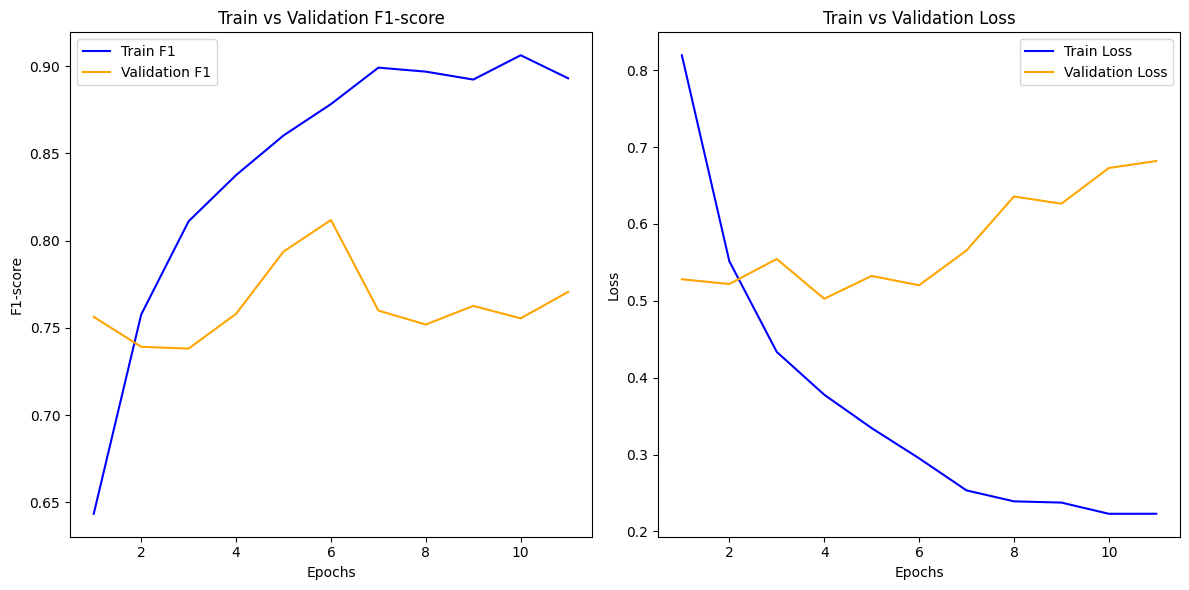

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-29-54234faa0c51>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more

              precision    recall  f1-score   support

     bruised       0.86      0.84      0.85        44
     cracked       0.63      0.67      0.65        18
      rotten       0.94      0.91      0.93        68
     spotted       0.46      0.67      0.54        57
  unaffected       0.90      0.78      0.84       175
      unripe       0.88      0.87      0.87        90

    accuracy                           0.81       452
   macro avg       0.78      0.79      0.78       452
weighted avg       0.83      0.81      0.81       452



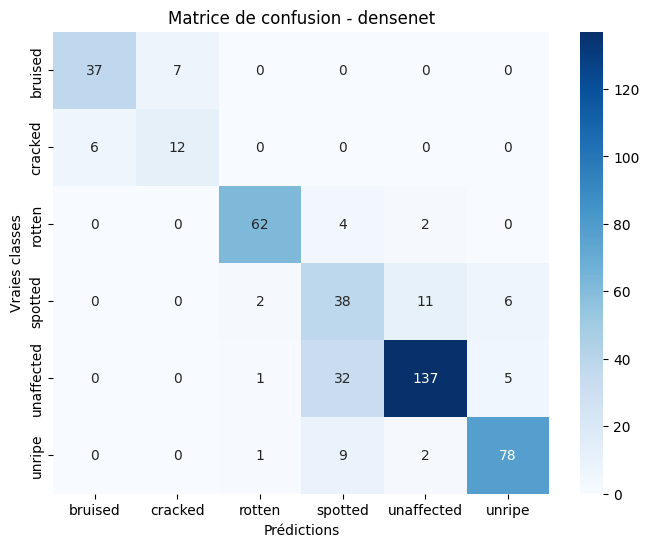

In [29]:
plot_training_curves(
    train_f1s_densenet,
    val_f1s_densenet,
    train_losses_densenet,
    val_losses_densenet
)

num_classes = 6  # adapte selon ton projet
model = build_model("densenet121", num_classes=num_classes).to(device)
model.load_state_dict(torch.load("densenet121_best.pth", map_location=device))
model.eval()

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        y_true += labels.cpu().tolist()
        y_pred += preds.cpu().tolist()

target_names = ['bruised', 'cracked', 'rotten', 'spotted', 'unaffected', 'unripe']  # adapte selon ton cas

print(classification_report(y_true, y_pred, target_names=target_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Prédictions")
plt.ylabel("Vraies classes")
plt.title("Matrice de confusion - densenet")
plt.show()
